In [28]:
import matplotlib.pyplot as plt
from collections import OrderedDict

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

Saved base distribution file: processed_csv_mod3/pubchem_base.csv


,Dataset,Count,E Mean,E Median,E Std,f Mean,f Median,f Std
0,MolDQN-RF,50,3.795,3.635,0.488,1.099,1.077,0.177
1,ReLeaSE-RF,50,6.932,6.973,0.882,0.199,0.164,0.087
2,MolDQN-MLP,50,3.856,3.731,0.353,0.751,0.736,0.103
3,ReLeaSE-MLP,50,3.181,2.478,1.742,0.424,0.371,0.188
4,MolFinder-RF,50,2.515,2.509,0.095,1.000,1.019,0.085
5,MolFinder-MLP,50,2.496,2.494,0.066,0.602,0.589,0.063
6,PubChemQC-500K,504554,5.211,5.230,0.909,0.301,0.280,0.203


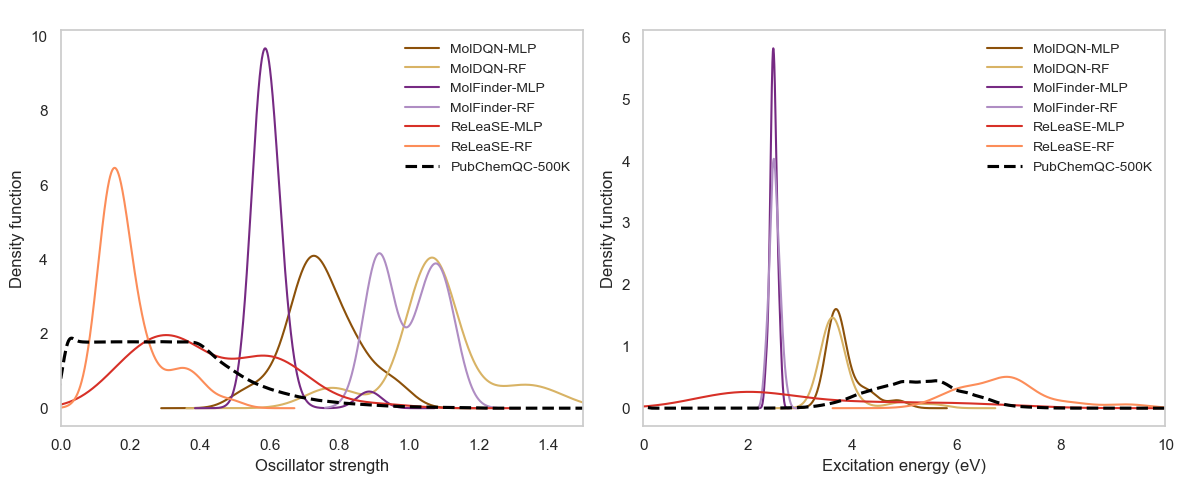

In [29]:


# 1) Extract base columns from PubChemQC raw file
raw_file = 'pubchemqc.csv'  # adjust path if needed
df_pub = pd.read_csv(raw_file, usecols=['smiles', 'ex', 'os'])
df_pub.columns = ['SMILES', 'ExcitationEnergy', 'OscillatorStrength']
os.makedirs('processed_csv', exist_ok=True)
df_pub.to_csv('processed_csv_mod3/pubchem_base.csv', index=False)
print("Saved base distribution file: processed_csv_mod3/pubchem_base.csv")

# 2) Load top‑N files and the new base distribution
input_dir = 'processed_csv_mod3'
paths = glob.glob(os.path.join(input_dir, '*_top*.csv'))
paths.append(os.path.join(input_dir, 'pubchem_base.csv'))

datasets = {}
for path in paths:
    name = os.path.basename(path).rsplit('_top', 1)[0] if '_top' in path else 'PubChemQC-500K'
    datasets[name] = pd.read_csv(path)

# 3) Compute and display summary statistics
summaries = []
for name, df in datasets.items():
    energy = df['ExcitationEnergy']
    osc = df['OscillatorStrength']
    summaries.append({
        'Dataset':   name,
        'Count':     len(df),
        'E Mean':    energy.mean(),
        'E Median':  energy.median(),
        'E Std':     energy.std(),
        'f Mean':    osc.mean(),
        'f Median':  osc.median(),
        'f Std':     osc.std()
    })

summary_df = pd.DataFrame(summaries)
display(summary_df.style.format({
    'E Mean': '{:.3f}', 'E Median': '{:.3f}', 'E Std': '{:.3f}',
    'f Mean': '{:.3f}', 'f Median': '{:.3f}', 'f Std': '{:.3f}'
}))

# Canonical model color dict with desired plotting order
model_color_dict = OrderedDict({
    "MolDQN-MLP": "#8c510a",
    "MolDQN-RF":  "#d8b365",
    "MolFinder-MLP": "#762a83",
    "MolFinder-RF":  "#af8dc3",
    "ReLeaSE-MLP": "#d73027",
    "ReLeaSE-RF":  "#fc8d59",
    "PubChemQC-500K": "black"
})

def plot_kde_trimmed(datasets, column, title, xlabel, xlim_max, bw_override=None):
    plt.figure(figsize=(9, 5))
    
    for name, color in model_color_dict.items():
        if name in datasets:
            df = datasets[name]
            data = df[column].dropna()
            data = data[data <= xlim_max]  # Remove extreme values
            if len(data) < 2:
                continue
            bw = bw_override.get(name, None) if bw_override else None
            linestyle = '--' if name == 'PubChemQC-500K' else '-'
            data.plot.kde(
                label=name,
                color=color,
                linewidth=2.25 if name == 'PubChemQC-500K' else 1.5,
                bw_method=bw,
                linestyle=linestyle
            )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density function')
    plt.xlim(0, xlim_max)
    plt.legend(
        fontsize=11,
        handlelength=3,
        handleheight=1.5,
        borderpad=1,
        loc='upper right',
        frameon=False
    )
    #plt.grid(True)
    plt.tight_layout()
    #plt.show()

# Apply bandwidth smoothing only to MolFinder-MLP
bandwidth_overrides = {
    "MolFinder-MLP": 0.5,
    "MolFinder-RF": 0.5  # Optional: also smooth this if needed
}


fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

def plot_kde_on_ax(ax, datasets, column, xlabel, xlim_max, bw_override=None):
    for name, color in model_color_dict.items():
        if name in datasets:
            df = datasets[name]
            data = df[column].dropna()
            data = data[data <= xlim_max]
            if len(data) < 2:
                continue
            bw = bw_override.get(name, None) if bw_override else None
            linestyle = '--' if name == 'PubChemQC-500K' else '-'
            data.plot.kde(
                ax=ax,
                label=name,
                color=color,
                linewidth=2.25 if name == 'PubChemQC-500K' else 1.5,
                bw_method=bw,
                linestyle=linestyle
            )
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density function')
    ax.set_xlim(0, xlim_max)
    ax.set_title(' ')  # no title
    ax.legend(
        fontsize=10,
        handlelength=2.5,
        loc='upper right',
        frameon=False
    )
    ax.grid(False)

# Plot both subfigures
plot_kde_on_ax(
    axes[1], datasets,
    column='ExcitationEnergy',
    xlabel='Excitation energy (eV)',
    xlim_max=10,
    bw_override=bandwidth_overrides
)

plot_kde_on_ax(
    axes[0], datasets,
    column='OscillatorStrength',
    xlabel='Oscillator strength',
    xlim_max=1.5,
    bw_override=bandwidth_overrides
)

plt.tight_layout()
plt.savefig("kde_subfigs_legends_insideGH#1.png", dpi=300, bbox_inches='tight')
plt.show()



In [30]:
import os
import glob
import pandas as pd
from rdkit import Chem
#from rdkit.Chem import rdMolOps
from rdkit.Chem import SanitizeMol

# --- Robust SMILES validation and canonicalization functions ---

def is_valid_smiles(smiles: str) -> bool:
    """
    Checks if a SMILES string yields a chemically valid RDKit molecule.
    Uses non-sanitized parsing followed by full sanitization with error catching.
    """
    if not isinstance(smiles, str) or not smiles.strip():
        return False
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        if mol is None:
            return False
        # Perform full sanitization; catchErrors=True returns a non-zero code on failure
        #err_code = rdMolOps.SanitizeMol(mol, catchErrors=True)
        err_code = Chem.SanitizeMol(mol, catchErrors=True)
        return err_code == 0
    except Exception:
        return False

def canonicalize_smiles(smiles: str) -> str:
    """
    Returns the canonical isomeric SMILES if valid, else returns None.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        return Chem.MolToSmiles(mol, isomericSmiles=True)
    except Exception:
        return None

# --- Batch processing of SMILES files ---

input_dir = 'processed_csv_mod3V'     # directory containing your CSV files with a 'SMILES' column
output_dir = 'validated_csv_mod3V'    # directory to save results
os.makedirs(output_dir, exist_ok=True)

for filepath in glob.glob(os.path.join(input_dir, '*.csv')):
    df = pd.read_csv(filepath)
    base = os.path.basename(filepath).rsplit('.', 1)[0]
    
    if 'SMILES' not in df.columns:
        raise ValueError(f"[{base}] Missing 'SMILES' column in {filepath}")
    
    # 1) Validate and canonicalize
    df['Valid'] = df['SMILES'].apply(is_valid_smiles)
    df['CanonicalSMILES'] = df['SMILES'].where(
        df['Valid'], None
    ).apply(lambda s: canonicalize_smiles(s) if s else None)
    
    # 2) Separate valid vs. invalid
    valid_df = df[df['Valid']].reset_index(drop=True)
    invalid_df = df[~df['Valid']].reset_index(drop=True)
    
    # 3) Save to CSV
    valid_path   = os.path.join(output_dir, f'{base}_valid.csv')
    invalid_path = os.path.join(output_dir, f'{base}_invalid.csv')
    df.to_csv(os.path.join(output_dir, f'{base}_annotated.csv'), index=False)  # full annotation
    valid_df.to_csv(valid_path, index=False)
    invalid_df.to_csv(invalid_path, index=False)
    
    # 4) Summary printout
    total   = len(df)
    valid_n = len(valid_df)
    print(f"[{base}] {total} total → {valid_n} valid ({valid_n/total:.1%}), {total-valid_n} invalid")
    print(f"  • Annotated: {output_dir}/{base}_annotated.csv")
    print(f"  • Valid SMILES: {valid_path}")
    print(f"  • Invalid SMILES: {invalid_path}\n")


[MoldqnMLP_top50] 50 total → 50 valid (100.0%), 0 invalid
  • Annotated: validated_csv_mod3V/MoldqnMLP_top50_annotated.csv
  • Valid SMILES: validated_csv_mod3V/MoldqnMLP_top50_valid.csv
  • Invalid SMILES: validated_csv_mod3V/MoldqnMLP_top50_invalid.csv

[MolfinderRF_top50] 50 total → 50 valid (100.0%), 0 invalid
  • Annotated: validated_csv_mod3V/MolfinderRF_top50_annotated.csv
  • Valid SMILES: validated_csv_mod3V/MolfinderRF_top50_valid.csv
  • Invalid SMILES: validated_csv_mod3V/MolfinderRF_top50_invalid.csv

[ReleaseRF_mod3_top50] 50 total → 46 valid (92.0%), 4 invalid
  • Annotated: validated_csv_mod3V/ReleaseRF_mod3_top50_annotated.csv
  • Valid SMILES: validated_csv_mod3V/ReleaseRF_mod3_top50_valid.csv
  • Invalid SMILES: validated_csv_mod3V/ReleaseRF_mod3_top50_invalid.csv

[MoldqnRF_top50] 50 total → 50 valid (100.0%), 0 invalid
  • Annotated: validated_csv_mod3V/MoldqnRF_top50_annotated.csv
  • Valid SMILES: validated_csv_mod3V/MoldqnRF_top50_valid.csv
  • Invalid SMILES: v

[21:16:16] Explicit valence for atom # 1 Br, 3, is greater than permitted
[21:16:16] Explicit valence for atom # 7 O, 3, is greater than permitted
[21:16:16] Explicit valence for atom # 5 N, 4, is greater than permitted
[21:16:16] Explicit valence for atom # 3 N, 4, is greater than permitted
[21:16:16] Explicit valence for atom # 6 Cl, 3, is greater than permitted


[21:16:16] Explicit valence for atom # 7 O, 3, is greater than permitted
[21:16:16] Explicit valence for atom # 1 Br, 3, is greater than permitted
[21:16:16] Explicit valence for atom # 5 N, 4, is greater than permitted
[21:16:16] Explicit valence for atom # 3 N, 4, is greater than permitted
[21:16:16] Explicit valence for atom # 6 Cl, 3, is greater than permitted


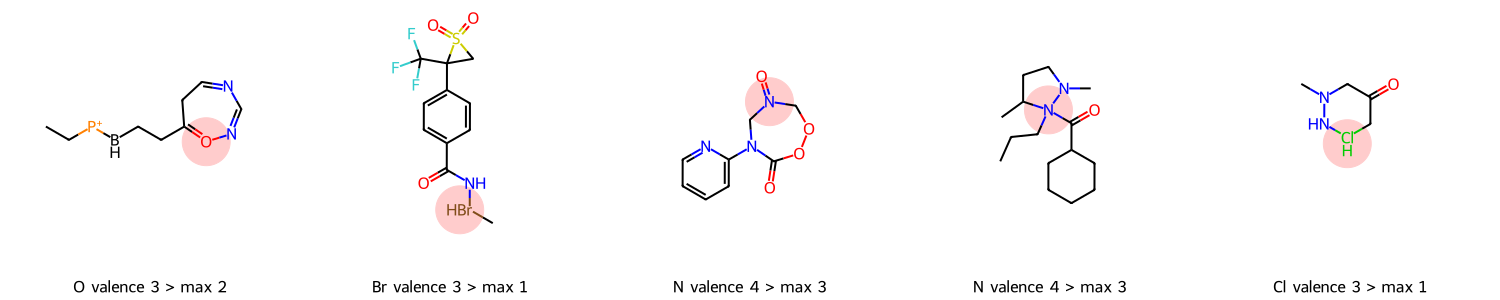

In [31]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
from IPython.display import display

# ── Settings ──
sub_img_size  = (300, 300)
mols_per_row    = 5
# a pastel‐pink highlight
highlight_color = (1.0, 0.8, 0.8)
highlight_rad   = 0.9

# ── Read your invalid SMILES CSV ──
input_csv = "validated_csv_mod3V/five-moles.csv"
df = pd.read_csv(input_csv)

# ── Prepare drawing options ──
rdDepictor.SetPreferCoordGen(True)
DrawingOptions.includeAtomNumbers = True

mols       = []
highlights = []
legends    = []
pt = Chem.GetPeriodicTable()

for smi in df["SMILES"]:
    # parse without sanitization so we can control error capture
    mol = Chem.MolFromSmiles(smi, sanitize=False)
    if mol is None:
        continue

    # generate 2D coords
    rdDepictor.Compute2DCoords(mol)

    # try full sanitize to capture RDKit error text
    try:
        Chem.SanitizeMol(mol)
        sanitize_err = None
    except Exception as e:
        sanitize_err = str(e).strip()

    # explicit‐valence check for exact numbers
    bad_idxs = []
    details  = []
    for atom in mol.GetAtoms():
        idx    = atom.GetIdx()
        sym    = atom.GetSymbol()
        val    = atom.GetExplicitValence() + atom.GetImplicitValence()
        maxv = max(list(pt.GetValenceList(atom.GetAtomicNum())))
        if val > maxv:
            bad_idxs.append(idx)
            details.append(f"{sym} valence {val} > max {maxv}")

    # skip if no issues found
    if sanitize_err is None and not bad_idxs:
        continue

    # build a reader‐friendly legend
    caption_lines = []
    caption_lines += details

    mols.append(mol)
    highlights.append(bad_idxs)
    legends.append("\n".join(caption_lines))

    if len(mols) >= mols_per_row:
        break

# ── Draw the grid ──
grid = Draw.MolsToGridImage(
    mols,
    molsPerRow         = mols_per_row,
    subImgSize         = sub_img_size,
    legends            = legends,
    highlightAtomLists = highlights,
    highlightAtomColors= [{i: highlight_color for i in bad} for bad in highlights],
    highlightAtomRadii = [{i: highlight_rad   for i in bad} for bad in highlights],
    useSVG             = False,  # get a PIL image
    returnPNG          = False
)

# ── Display & save ──
display(grid)
grid.save("invalid_valence_with_reasons.png")


In [32]:
!ls -ll RawScores/

total 136
-rw-r--r--@ 1 braket  staff   8947 Apr 22 04:20 MolDQN-MLP_top50_scores.csv
-rw-r--r--@ 1 braket  staff   8490 Apr 22 04:20 MolDQN-RF_top50_scores.csv
-rw-r--r--@ 1 braket  staff  10521 Apr 22 04:20 MolFinder-MLP_top50_scores.csv
-rw-r--r--@ 1 braket  staff   9844 Apr 22 04:20 MolFinder-RF_top50_scores.csv
-rw-r--r--@ 1 braket  staff   6380 Apr 22 04:20 ReLeaSE-MLP_mod3_top50_scores.csv
-rw-r--r--@ 1 braket  staff   9781 Apr 22 04:20 ReLeaSE-RF_mod3_top50_scores.csv


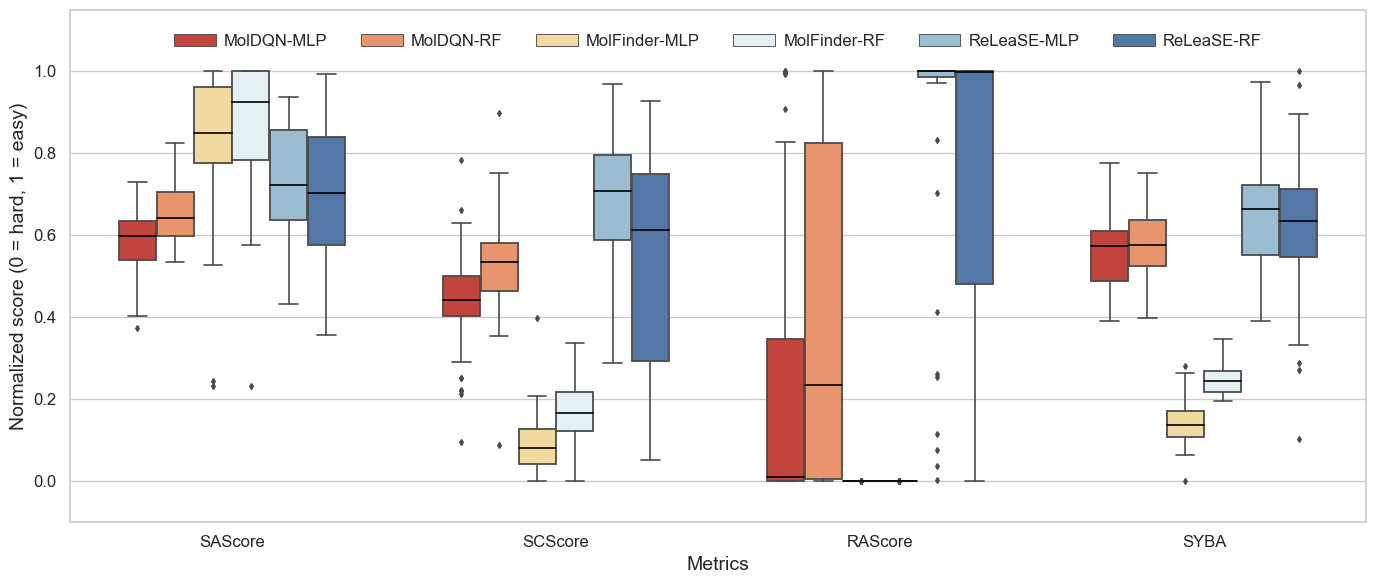

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
import os

# ─── Configuration ───
csv_dir = "RawScores"
model_files = [
    "MolDQN-MLP_top50_scores.csv",
    "MolDQN-RF_top50_scores.csv",
    "MolFinder-MLP_top50_scores.csv",
    "MolFinder-RF_top50_scores.csv",
    "ReLeaSE-MLP_mod3_top50_scores.csv",
    "ReLeaSE-RF_mod3_top50_scores.csv"
]
model_names = [fname.split("_")[0] for fname in model_files]

# ─── Find global SYBA min and max across all models ───
syba_mins = []
syba_maxs = []

for file in model_files:
    df_temp = pd.read_csv(os.path.join(csv_dir, file))
    df_temp["SYBA"] = pd.to_numeric(df_temp["SYBA"], errors="coerce")
    df_temp = df_temp.dropna(subset=["SYBA"])
    syba_mins.append(df_temp["SYBA"].min())
    syba_maxs.append(df_temp["SYBA"].max())

global_syba_min = min(syba_mins)
global_syba_max = max(syba_maxs)

# print(f"Global SYBA range for normalization: {global_syba_min:.2f} to {global_syba_max:.2f}")

# Helper functions
def scaler(value, low, high):
    value = max(min(value, high), low)
    return (value - low) / (high - low)

def inverted_scaler(value, low, high):
    return 1.0 - scaler(value, low, high)

# Processing loop
dfs = []
for file, model_name in zip(model_files, model_names):
    df = pd.read_csv(os.path.join(csv_dir, file))
    
    # Convert score columns to numeric, invalids become NaN
    for col in ["SAscore", "SCScore", "RAscore", "SYBA"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Drop rows with any NaNs in relevant columns
    df_valid = df.dropna(subset=["SAscore", "SCScore", "RAscore", "SYBA"]).copy()

    # Normalize
    df_valid["Norm_SAScore"] = df_valid["SAscore"].apply(lambda x: inverted_scaler(x, 1, 10))
    df_valid["Norm_SCScore"] = df_valid["SCScore"].apply(lambda x: inverted_scaler(x, 1, 5))
    df_valid["Norm_RAScore"] = df_valid["RAscore"].apply(lambda x: scaler(x, 0, 1))
    #df_valid["Norm_SYBA"]    = df_valid["SYBA"].apply(lambda x: scaler(x, -175, 150))
    df_valid["Norm_SYBA"] = df_valid["SYBA"].apply(lambda x: scaler(x, global_syba_min, global_syba_max))
    df_valid["Model"] = model_name

    dfs.append(df_valid[["Model", "SMILES", "Norm_SAScore", "Norm_SCScore", "Norm_RAScore", "Norm_SYBA"]])

# ─── Combine all models ───
df_all = pd.concat(dfs, ignore_index=True)
# Save all normalized scores from all models to a single CSV
#df_all.to_csv("all_models_normalized_scores.csv", index=False)
df_all.to_csv("all_models_normalized_scores_A.csv", index=False)


# ─── Clean model colors & data melt (assumed already done above) ───
df_melted = df_all.melt(
    id_vars=["Model", "SMILES"],
    value_vars=["Norm_SAScore", "Norm_SCScore", "Norm_RAScore", "Norm_SYBA"],
    var_name="Metric",
    value_name="Score"
)
df_melted["Metric"] = df_melted["Metric"].str.replace("Norm_", "")

# Palette from model names

models = df_melted["Model"].unique()
# palette = sns.color_palette("husl", len(models))
# model_color_dict = dict(zip(models, palette))
model_color_dict = {
    "MolDQN-MLP": "#d73027",  # red
    "MolDQN-RF":  "#fc8d59",  # light red
    "MolFinder-MLP": "#fee090",  # blue
    "MolFinder-RF":  "#e0f3f8",  # light blue
    "ReLeaSE-MLP": "#91bfdb",  # green (if added later)
    "ReLeaSE-RF":  "#4575b4"   # light green
}

# ─── Plot ───
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))  # slightly narrower for better clustering

# Main plot
sns.boxplot(
    data=df_melted,
    x="Metric",            # X-axis: metric category (SAScore, etc.)
    y="Score",             # Y-axis: normalized score
    hue="Model",           # Separate boxes by model (6 per metric group)
    linewidth=1.3,         # Thickness of the box edge
    fliersize=3,           # Size of outlier dots
    dodge=True,            # Group boxes side-by-side within each metric
    width=0.7,             # Width of each box — smaller = more spacing within metric
    palette=model_color_dict,   # Use your custom color scheme
    medianprops=dict(color='black', linewidth=1.2),     # Style median line
    whiskerprops=dict(linewidth=1.2),                   # Style whiskers
    capprops=dict(linewidth=1.2)                        # Style end caps
)

# Adjust axis & text
plt.ylim(-0.1, 1.15)
plt.yticks(np.arange(0.0, 1.05, 0.2)) 
#plt.title("Synthetic accessibility Score Distributions per Model", fontsize=15)
plt.ylabel("Normalized score (0 = hard, 1 = easy)", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend: inside top-right, with margin from boxes
plt.legend(
    #title="Model",               
    #loc="upper right",           
    #bbox_to_anchor=(1.0, 1.0),   
    loc="upper center",           
    bbox_to_anchor=(0.5, 0.98),   
    borderaxespad=0.4,            
    frameon=False,                
    fontsize=12,                  
    #title_fontsize=11,           
    labelspacing=0.6,             
    handlelength=2.5,             
    handletextpad=0.5,            
    borderpad=0.4,                
    ncol=len(model_color_dict)    
)

# Final layout with room for legend inside
plt.tight_layout(rect=[0, 0, 1, 1])  # makes room for legend on right side
plt.savefig("synthetic_accessibility_boxplot_tunedz.png", dpi=300)
plt.show()



In [34]:
# ─── Find global SYBA min and max across all models ───
syba_mins = []
syba_maxs = []

for file in model_files:
    df_temp = pd.read_csv(os.path.join(csv_dir, file))
    df_temp["SYBA"] = pd.to_numeric(df_temp["SYBA"], errors="coerce")
    df_temp = df_temp.dropna(subset=["SYBA"])
    syba_mins.append(df_temp["SYBA"].min())
    syba_maxs.append(df_temp["SYBA"].max())

global_syba_min = min(syba_mins)
global_syba_max = max(syba_maxs)

print(f"Global SYBA range for normalization: {global_syba_min:.2f} to {global_syba_max:.2f}")


Global SYBA range for normalization: -177.63 to 91.91


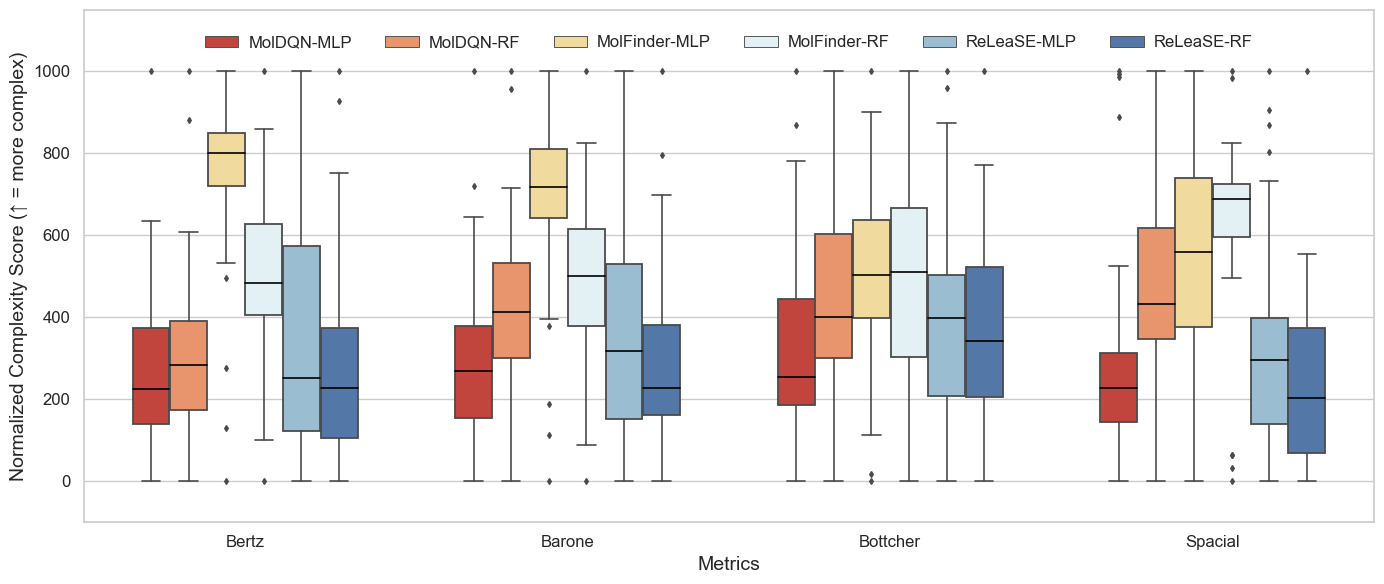

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# ─── Configuration ───
csv_dir = "RawScores_Complexity"
model_files = [
    "MolDQN-MLP_top50_scores+complexity.csv",
    "MolDQN-RF_top50_scores+complexity.csv",
    "MolFinder-MLP_top50_scores+complexity.csv",
    "MolFinder-RF_top50_scores+complexity.csv",
    "ReLeaSE-MLP_top50_scores+complexity.csv",
    "ReLeaSE-RF_top50_scores+complexity.csv"
]
model_names = [fname.split("_")[0] for fname in model_files]

# ─── Normalize helper ───
def minmax_scale(series, min_val=1, max_val=1000):
    return ((series - series.min()) / (series.max() - series.min())) * (max_val - min_val) + min_val

# ─── Process all model files ───
dfs = []
for file, model_name in zip(model_files, model_names):
    path = os.path.join(csv_dir, file)
    df = pd.read_csv(path)
    
    # Select valid complexity columns
    cols = ["Bertz", "Barone", "Bottcher", "Spacial"]
    df = df.dropna(subset=cols).copy()

    for col in cols:
        df[f"Norm_{col}"] = minmax_scale(df[col])

    df["Model"] = model_name
    dfs.append(df[["Model", "SMILES"] + [f"Norm_{col}" for col in cols]])

# ─── Combine and melt ───
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_csv("all_models_normalized_scores_B.csv", index=False)



df_melted = df_all.melt(
    id_vars=["Model", "SMILES"],
    value_vars=["Norm_Bertz", "Norm_Barone", "Norm_Bottcher", "Norm_Spacial"],
    var_name="Metric",
    value_name="Score"
)
df_melted["Metric"] = df_melted["Metric"].str.replace("Norm_", "")

# ─── Color mapping ───
model_color_dict = {
    "MolDQN-MLP": "#d73027",
    "MolDQN-RF": "#fc8d59",
    "MolFinder-MLP": "#fee090",
    "MolFinder-RF": "#e0f3f8",
    "ReLeaSE-MLP": "#91bfdb",
    "ReLeaSE-RF": "#4575b4"
}

# ─── Plot ───
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

sns.boxplot(
    data=df_melted,
    x="Metric",
    y="Score",
    hue="Model",
    linewidth=1.3,
    fliersize=3,
    dodge=True,
    width=0.7,
    palette=model_color_dict,
    medianprops=dict(color='black', linewidth=1.2),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2)
)

plt.ylim(-100, 1150)
plt.yticks(np.arange(0, 1050, 200))
#plt.ylabel("Min–Max Normalized Score (Scaled to [1–1000])", fontsize=14)
plt.ylabel("Normalized Complexity Score (↑ = more complex)", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(
    loc="upper center",        # Top center of the plot
    bbox_to_anchor=(0.5, 0.98),# Slightly above the plot area
    frameon=False,
    fontsize=12,
    labelspacing=0.5,
    handlelength=2,
    handletextpad=0.6,
    borderpad=0.4,
    ncol=len(model_color_dict)  # One row, as many columns as models
)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("complexity_metrics_boxplot_1to1000z.png", dpi=300)
plt.show()


In [36]:
import pandas as pd

# Load both CSV files
df_A = pd.read_csv('all_models_normalized_scores_A.csv')
df_B = pd.read_csv('all_models_normalized_scores_B.csv')

# Check if the first two columns match (for safety!)
if not df_A.iloc[:, :2].equals(df_B.iloc[:, :2]):
    raise ValueError("First two columns (Model and SMILES) do not match between the files!")

# Merge: take first two columns from df_A, then 4+4 columns
merged = pd.concat([df_A, df_B.iloc[:, 2:]], axis=1)

# Save the merged result
merged.to_csv('merged_all_models_scores.csv', index=False)

print(" Merge successful! Saved as 'merged_all_models_scores.csv'")


 Merge successful! Saved as 'merged_all_models_scores.csv'


In [37]:
import os
import pandas as pd
from rdkit import Chem

# Inputs
fluorescence_path = "fluorescence_summary_neutral_only.csv"
features_path = "merged_all_models_scores.csv"
rawscores_dir = "RawScores"
output_path = "final_matched_fluorescence_features.csv"

# Load files
df_fluor = pd.read_csv(fluorescence_path)
df_features = pd.read_csv(features_path)

# Canonicalization function
def canon(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return Chem.MolToSmiles(mol, canonical=True) if mol else None
    except:
        return None

# ─── Canonicalize SMILES from RawScores to add to df_fluor ───
df_fluor["Canonical_SMILES"] = None

for idx, row in df_fluor.iterrows():
    model = row['Model']
    mol_id = row['MoleculeID']
    mol_idx = int(mol_id.replace("mol", ""))

    model_file = os.path.join(rawscores_dir, f"{model}_top50_scores.csv")
    if not os.path.exists(model_file):
        print(f"⚠ Missing: {model_file}")
        continue

    try:
        df_model = pd.read_csv(model_file)
        smiles = df_model.iloc[mol_idx, 0]  # assumes SMILES in first column
        df_fluor.at[idx, "Canonical_SMILES"] = canon(smiles)
    except Exception as e:
        print(f"⚠ Error for {model}/{mol_id}: {e}")

# ─── Canonicalize SMILES in features file ───
df_features["Canonical_SMILES"] = df_features["SMILES"].apply(canon)

# ─── Merge on Canonical_SMILES ───
df_merged = pd.merge(df_features, df_fluor,
                     on="Canonical_SMILES",
                     how="inner",
                     suffixes=("_features", "_fluor"))

# ─── Reorder or select columns ───
columns_order = [
    "Model_fluor", "MoleculeID", "SMILES", "Canonical_SMILES",
    "Energy_eV", "OscillatorStrength_fL", "Amplitude", "Transition",
    "Norm_SAScore", "Norm_SCScore", "Norm_RAScore", "Norm_SYBA",
    "Norm_Bertz", "Norm_Barone", "Norm_Bottcher", "Norm_Spacial"
]
df_final = df_merged[columns_order].rename(columns={"Model_fluor": "Model"})

# ─── Save result ───
df_final.to_csv(output_path, index=False)
print(f" Final matched file saved: {output_path}")
print(f" Matched unique molecules: {df_final['Canonical_SMILES'].nunique()} / {len(df_fluor)}")


 Final matched file saved: final_matched_fluorescence_features.csv
 Matched unique molecules: 54 / 63


In [38]:
import pandas as pd
import numpy as np

# ─── Load Data ───
df = pd.read_csv("final_matched_fluorescence_features.csv")

# ─── Calculate Geometric Mean Scores ───
df["SynthScore"] = (
    df["Norm_SAScore"] * df["Norm_SCScore"] * df["Norm_RAScore"] * df["Norm_SYBA"]
) ** 0.25

df["ComplexityScore"] = (
    df["Norm_Bertz"] * df["Norm_Barone"] * df["Norm_Bottcher"] * df["Norm_Spacial"]
) ** 0.25

# ─── Post-process ───
cols_to_round = [
    "Norm_SAScore", "Norm_SCScore", "Norm_RAScore", "Norm_SYBA",
    "Norm_Bertz", "Norm_Barone", "Norm_Bottcher", "Norm_Spacial",
    "SynthScore", "ComplexityScore"
]
df[cols_to_round] = df[cols_to_round].round(3)

df.drop(columns=["Transition"], errors="ignore", inplace=True)

# ─── Save Full Scored Dataset ───
df.to_csv("final_with_geom_scores.csv", index=False)

# ─── Apply Threshold Filtering ───
synth_thresh = 0.4
complexity_thresh = 400
filtered = df[(df["SynthScore"] >= synth_thresh) & (df["ComplexityScore"] <= complexity_thresh)]

# ─── Save Filtered Results ───
filtered.to_csv("filtered_molecules.csv", index=False)
print(f"{len(filtered)} molecules saved to 'filtered_molecules.csv'")



32 molecules saved to 'filtered_molecules.csv'


In [39]:
display(filtered)


,Model,MoleculeID,SMILES,Canonical_SMILES,Energy_eV,OscillatorStrength_fL,Amplitude,Norm_SAScore,Norm_SCScore,Norm_RAScore,Norm_SYBA,Norm_Bertz,Norm_Barone,Norm_Bottcher,Norm_Spacial,SynthScore,ComplexityScore
10,MolDQN-MLP,mol032,C=Cn1cccc1C=C1C=CC(O)=N1,C=Cn1cccc1C=C1C=CC(O)=N1,3.691,0.863330,0.96,0.663,0.461,0.531,0.575,124.621,126.748,119.861,157.666,0.553,131.443
13,MolDQN-MLP,mol037,Cn1cccc1C=C1C=CC(O)=N1,Cn1cccc1C=C1C=CC(O)=N1,3.824,1.384930,-0.98,0.719,0.430,0.994,0.680,74.369,84.832,77.497,143.424,0.676,91.509
14,MolDQN-MLP,mol040,NC1=NC(=Cc2cccn2B(F)F)C=C1,NC1=NC(=Cc2cccn2B(F)F)C=C1,3.629,1.074765,0.96,0.640,0.424,0.240,0.622,137.499,154.692,172.755,186.151,0.449,161.721
15,MolDQN-MLP,mol041,C=CBn1cccc1C=C1C=CC(N)=N1,C=CBn1cccc1C=C1C=CC(N)=N1,3.353,0.675282,-0.95,0.603,0.436,0.997,0.608,145.499,154.692,198.845,173.943,0.632,167.037
16,MolDQN-MLP,mol041,C=CBn1cccc1C=C1C=CC(N)=N1,C=CBn1cccc1C=C1C=CC(N)=N1,4.321,0.257813,0.92,0.603,0.436,0.997,0.608,145.499,154.692,198.845,173.943,0.632,167.037
17,MolDQN-MLP,mol043,NC1=CC=Cc2cccn2CC=C1N,NC1=CC=Cc2cccn2CC=C1N,4.176,0.333376,0.95,0.634,0.537,0.800,0.488,88.669,161.678,167.051,206.497,0.604,149.124
19,MolDQN-RF,mol001,CC=CC=Cc1ccc(C)n1CC,CC=CC=Cc1ccc(C)n1CC,4.330,0.873590,0.97,0.776,0.515,1.000,0.625,126.106,143.714,297.167,160.465,0.707,171.456
20,MolDQN-RF,mol002,Cn1cc(N)cc1C=CC=CC=N,Cn1cc(N)cc1C=CC=CC=N,3.418,0.983465,0.95,0.700,0.536,0.483,0.558,170.625,198.604,387.951,132.324,0.564,204.226
21,MolDQN-RF,mol002,Cn1cc(N)cc1C=CC=CC=N,Cn1cc(N)cc1C=CC=CC=N,4.301,0.779013,-0.94,0.700,0.536,0.483,0.558,170.625,198.604,387.951,132.324,0.564,204.226
22,MolDQN-RF,mol003,C1=CCn2cccc2C=C1,C1=CCn2cccc2C=C1,4.310,0.313985,-0.95,0.722,0.684,1.000,0.512,69.375,187.626,221.535,277.718,0.709,168.223
